# The Reuters dataset

A set of short newswires and their topics, published in Reuters in 1986. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

## 1. Loading the data



In [1]:
# Loading the Reuters dataset

from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2023424/2110848 [===========================>..] - ETA: 0s

In [3]:
len(train_data)


8982

In [4]:
len(test_data)

2246

In [6]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3,'?') for i in train_data[0]])
# the indices are offset by 3 because 0,1,2 are reserved indices for 'padding', 'start of sequence', and 'unknown'

In [8]:
train_labels[10]

3

## 2. Preparing the data

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence]=1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [15]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 3. Building your network

In the stack of Dense layes, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each leary can potentially become an information bottleneck. 

In [12]:
# Model definition

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation ='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation ='relu'))
model.add(layers.Dense(46, activation ='softmax'))

The network ends with a Dense layer of size 46, i.e. for each input sample, the network will output a 46-dimensional vector. Each entry in this vector will encode a different output class.

The last layer uses a softmax activation. It means the network will output a probability distribution over the 46 different output classes - for every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. 

In [13]:
# Compiling the model
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## 4. Validating your approach



In [16]:
# Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [21]:
# Training the model

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size = 512,
                   validation_data = (x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s - loss: 0.1055 - acc: 0.9573 - val_loss: 1.1099 - val_acc: 0.7970
Epoch 2/9
7982/7982 [==============================] - 1s - loss: 0.1016 - acc: 0.9584 - val_loss: 1.1107 - val_acc: 0.8040
Epoch 3/9
7982/7982 [==============================] - 1s - loss: 0.1018 - acc: 0.9588 - val_loss: 1.1018 - val_acc: 0.7930
Epoch 4/9
7982/7982 [==============================] - 1s - loss: 0.1029 - acc: 0.9577 - val_loss: 1.1286 - val_acc: 0.7960
Epoch 5/9
7982/7982 [==============================] - 1s - loss: 0.0968 - acc: 0.9595 - val_loss: 1.1546 - val_acc: 0.8020
Epoch 6/9
7982/7982 [==============================] - 1s - loss: 0.0987 - acc: 0.9563 - val_loss: 1.2295 - val_acc: 0.7910
Epoch 7/9
7982/7982 [==============================] - 1s - loss: 0.0957 - acc: 0.9570 - val_loss: 1.1830 - val_acc: 0.8000
Epoch 8/9
7982/7982 [==============================] - 1s - loss: 0.0918 - acc: 0.95

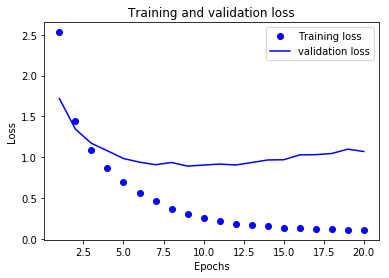

In [19]:
# Plotting the training and validation loss
plt.clf()
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = "validation loss")
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

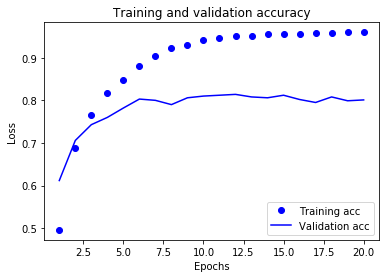

In [20]:
# Ploting the training and validation accuracy
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
results = model.evaluate(x_test, one_hot_test_labels)

1888/2246 [========================>.....] - ETA: 0s

## 5. Generating predictions

In [23]:
predictions = model.predict(x_test)

In [25]:
np.argmax(predictions[0])

3

## 6. Handle the labels and the loss

Another way to encode the labels: cast them as an integer tensor


In [26]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In this approach, the choice of loss function needs to be changed (same menaing mathematically but different interface)


In [27]:
model.compile(optimizer='rmsprop',
             loss = 'sparse_categorical_crossentropy',
             metrics=['acc'])

# Wrapping up

- When trying to classify data points among N classes, your network should end with a Dense layer of size N
- In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over N output classes
- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the tarfets
- Two ways to handle labels in multiclass classification:
+ Encoding the labels via categorical encoding (one-hot encoding) and use categorical_crossentropy as a loss function
+ Encoding the labels as intefers and using the sparse_categorical_crossentropy loss function
- If it is required to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.
